In [1]:
import os
import cv2
import time
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import (
    models,
    layers,
) 
from tensorflow.keras.layers import (
    Dense,
    Flatten,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
model_directory = 'models'

In [3]:
class RandomIntegers():
    def __init__(self):
        pass
    
    def generate(self, n, length):
        # Generate n unique random integers between 0 and length
        random_integers = random.sample(range(length), n)
        
        return random_integers

In [4]:
(x_train,y_train), (x_test, y_test)= mnist.load_data()

In [5]:
IMG_SIZE = 32
def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in range(len(img_array)):
        img = img_array[i].reshape(28, 28).astype('uint8')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')/255
        tmp[i] = img
        
    return tmp

x_train = resize(x_train)
x_test = resize(x_test)
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

In [6]:
x_train.shape

(60000, 32, 32, 3)

## Plot Dataset

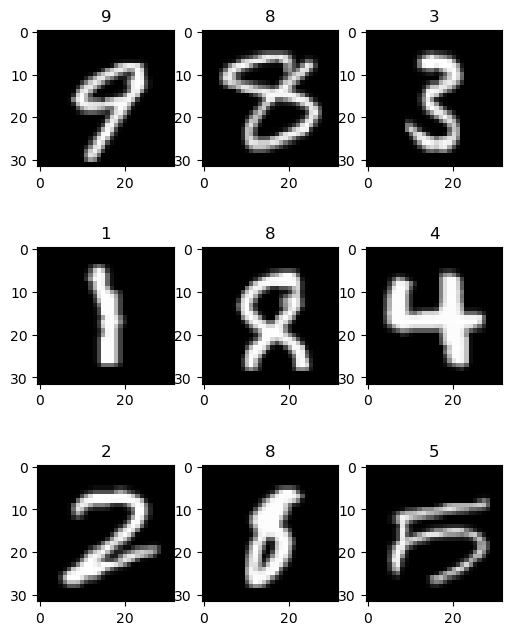

In [7]:
def display_images():
    random_integers = RandomIntegers().generate(9, len(x_train))
    plt.figure(figsize=(6, 8))
    counter = 0
    for i in random_integers:
        # define subplot
        plt.subplot(330 + 1 + counter)
        counter += 1
        # plot raw pixel data
        plt.imshow(x_train[i])
        plt.title(str(y_train[i]))
    # show the figure
    plt.show()
display_images()

In [8]:
# Preprocess the data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Load VGG and Build Model

In [10]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 20029514 (76.41 MB)
Trainable params: 20029514 (76.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the model

In [11]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.CategoricalAccuracy()],
# )

model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

#### EarlyStopping and Callback

In [12]:
# callback

es = EarlyStopping(monitor='val_acc', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='mnist-vgg19.h5', verbose=1, monitor='val_acc')
cb = [es, mc]

### Model Training

In [13]:
start_time = time.time()
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=cb)
end_time = time.time()
total_time = end_time - start_time

print("Time taken for training: ", total_time, " seconds")

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9325WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: saving model to mnist-vgg19.h5
469/469 [==============================] - 123s 260ms/step - loss: 0.2106 - accuracy: 0.9325 - val_loss: 0.0296 - val_accuracy: 0.9898
Epoch 2/15


/Users/binilkuriachan/anaconda3/envs/ail-411-env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9902WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: saving model to mnist-vgg19.h5
469/469 [==============================] - 122s 259ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0241 - val_accuracy: 0.9920
Epoch 3/15
469/469 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9930WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 3: saving model to mnist-vgg19.h5
469/469 [==============================] - 117s 250ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0238 - val_accuracy: 0.9927
Epoch 4/15
469/469 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9945WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is n

### Plot Accuracy

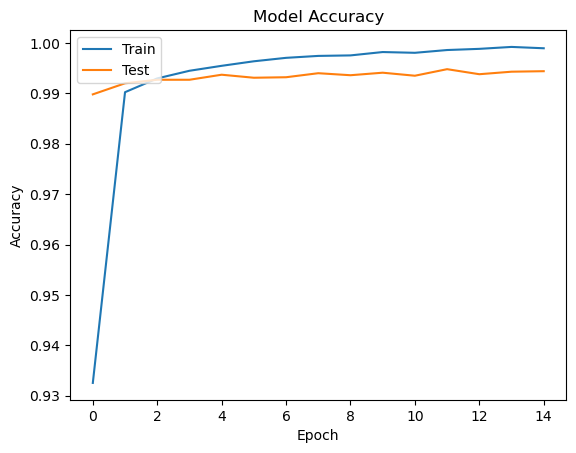

In [14]:
# Plot the accuracy from the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Plot loss

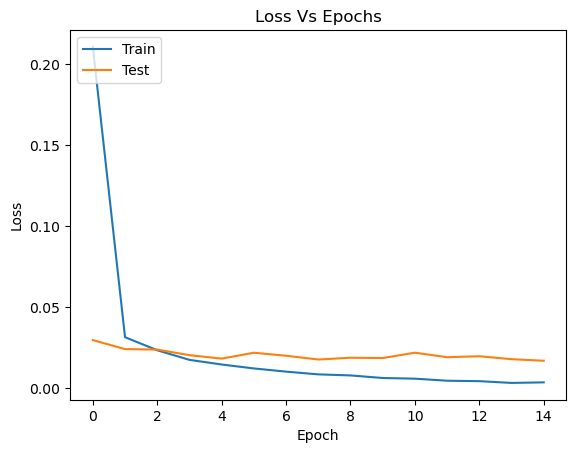

In [15]:
# Plot the accuracy from the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save Model

In [16]:
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory,"model_mnist_vgg.h5")
model.save(model_path)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 20029514 (76.41 MB)
Trainable params: 20029514 (76.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Get the true labels and predicted labels for the test dataset
true_labels = np.argmax(y_test, axis=-1)
predicted_labels = np.argmax(model.predict(x_test), axis=-1)


313/313 [==============================] - 6s 17ms/step


### Confusion Matrix

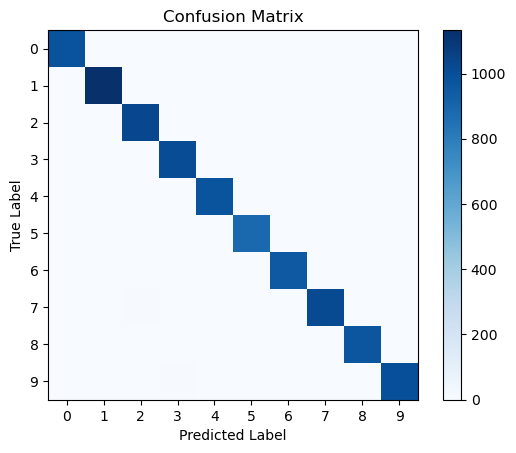

In [19]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

In [20]:
cm

array([[ 979,    0,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1133,    0,    1,    0,    0,    1,    0,    0,    0],
       [   1,    0, 1028,    1,    0,    0,    0,    2,    0,    0],
       [   0,    0,    1, 1007,    0,    2,    0,    0,    0,    0],
       [   0,    0,    0,    0,  978,    0,    0,    1,    0,    3],
       [   1,    0,    0,    4,    0,  886,    0,    0,    0,    1],
       [   2,    0,    1,    0,    0,    2,  952,    0,    1,    0],
       [   0,    2,    5,    1,    1,    0,    0, 1017,    1,    1],
       [   0,    0,    1,    1,    1,    1,    0,    1,  967,    2],
       [   0,    0,    0,    6,    4,    0,    0,    0,    2,  997]])

### Classification Report

In [21]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

